In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchinfo import summary

In [3]:
workers = 4
batch_size = 128

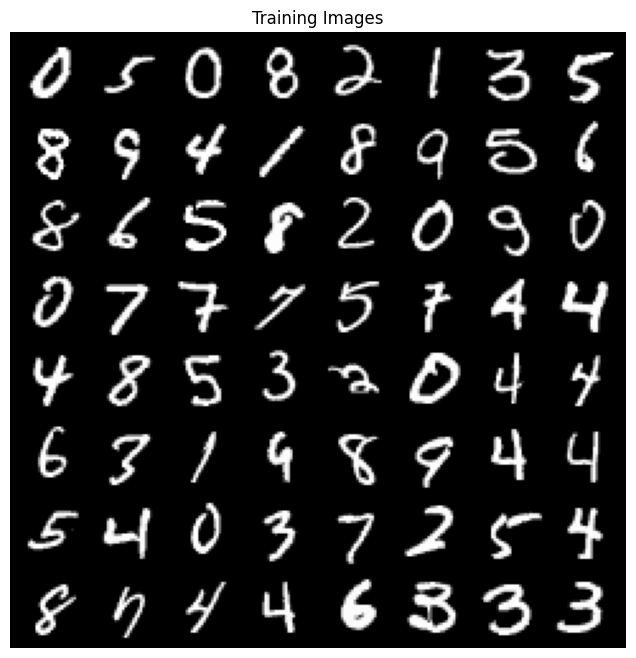

In [4]:
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST("./data", download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 10

batch_sample = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            batch_sample[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    ),
    cmap="gray",
)

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
nz = 100


class Generator(nn.Module):
    def __init__(self, nc=1, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # (ngf*4)*5*5
            nn.ConvTranspose2d(nz + num_classes, ngf * 4, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*2)*10*10
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf)*14*14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (nc)*28*28
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, inputs):
        return self.main(inputs)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (ndf)*14*14
            nn.Conv2d(nc + num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2)*10*10
            nn.Conv2d(ndf, ndf * 2, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 5, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        return self.main(inputs)

In [8]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [9]:
criterion = nn.BCELoss()

num_samples = 64
fixed_noise_label = torch.arange(0, num_samples, device=device) % 10
fixed_one_hot_label = F.one_hot(fixed_noise_label, num_classes=num_classes)[
    :, :, None, None
]
fixed_noise = torch.cat(
    (torch.randn(64, nz, 1, 1, device=device), fixed_one_hot_label), 1
)
print(fixed_noise.size())

real_label = 1.0
fake_label = 0.0

torch.Size([64, 110, 1, 1])


In [10]:
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))

In [11]:
epochs = 20

In [12]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training...")
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # 正解画像を使って識別機を訓練する
        netD.zero_grad()
        real_images = data[0].to(device)
        real_labels = data[1].to(device)
        b_size = real_images.size(0)

        real_one_hot_labels = torch.zeros(b_size, num_classes, 28, 28, device=device)

        real_one_hot_labels[:, real_labels].fill_(real_label)
        real_images = torch.cat(
            (
                real_images,
                real_one_hot_labels,
            ),
            1,
        )
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # 次元がb_size*1*1*1なのでreshape
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)

        # 正解画像の逆伝播
        errD_real.backward()
        D_x = output.mean().item()

        # 生成器の画像=偽物画像を使って識別機を訓練する
        noise_label = torch.randint(0, num_classes, (b_size,), device=device)
        noise_one_hot_label = F.one_hot(noise_label, num_classes=num_classes)[
            :, :, None, None
        ]
        noise = torch.cat(
            (
                torch.randn(b_size, nz, 1, 1, device=device),
                noise_one_hot_label,
            ),
            1,
        )
        fake_images = netG(noise)

        label.fill_(fake_label)
        noise_one_hot_label_2D = torch.zeros(b_size, num_classes, 28, 28, device=device)
        noise_one_hot_label_2D[:, noise_label].fill_(real_label)

        fake_images = torch.cat(
            (
                fake_images,
                noise_one_hot_label_2D,
            ),
            1,
        )
        # 判定
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        # 偽物画像の逆伝播
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # 先程の結果を使って生成器を訓練する
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake_images).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\t"
                % (epoch, epochs, i, len(dataloader), errD.item(), errG.item(),D_x,)
            )

        if iters % 500 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(
                torchvision.utils.make_grid(fake, padding=2, normalize=True)
            )
        iters += 1

Starting Training...
[0/20][0/468]	Loss_D: 1.9378	Loss_G: 1.5791	D(x): 0.7168	
[0/20][50/468]	Loss_D: 0.2453	Loss_G: 6.2089	D(x): 0.9247	
[0/20][100/468]	Loss_D: 0.0723	Loss_G: 5.3242	D(x): 0.9790	
[0/20][150/468]	Loss_D: 0.2038	Loss_G: 2.8622	D(x): 0.8814	
[0/20][200/468]	Loss_D: 0.1542	Loss_G: 3.2129	D(x): 0.9453	
[0/20][250/468]	Loss_D: 0.0723	Loss_G: 3.9584	D(x): 0.9726	
[0/20][300/468]	Loss_D: 0.3908	Loss_G: 2.5941	D(x): 0.8705	
[0/20][350/468]	Loss_D: 0.1614	Loss_G: 2.9024	D(x): 0.9133	
[0/20][400/468]	Loss_D: 0.4834	Loss_G: 4.1583	D(x): 0.9292	
[0/20][450/468]	Loss_D: 0.1191	Loss_G: 3.5934	D(x): 0.9652	
[1/20][0/468]	Loss_D: 0.0886	Loss_G: 3.3928	D(x): 0.9643	
[1/20][50/468]	Loss_D: 0.6421	Loss_G: 1.8112	D(x): 0.7551	
[1/20][100/468]	Loss_D: 0.1636	Loss_G: 2.9167	D(x): 0.9298	
[1/20][150/468]	Loss_D: 0.0936	Loss_G: 3.9282	D(x): 0.9791	
[1/20][200/468]	Loss_D: 4.6279	Loss_G: 0.3579	D(x): 0.0242	
[1/20][250/468]	Loss_D: 0.4814	Loss_G: 1.2558	D(x): 0.7285	
[1/20][300/468]	Loss_D: 0

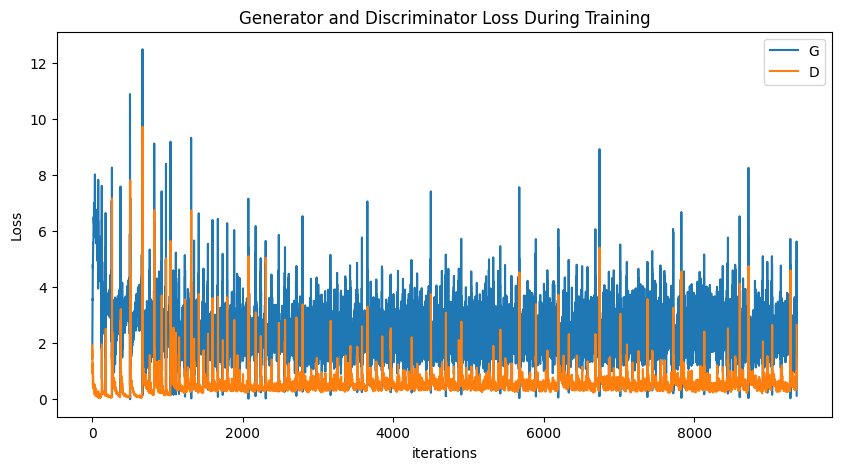

In [13]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

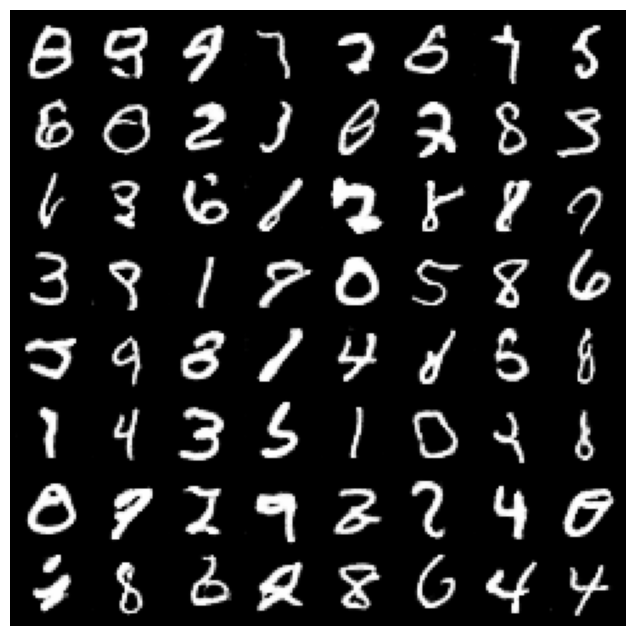

In [14]:
#%%capture
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())